In [1]:
import random
random.seed(10)
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import binom, beta, percentileofscore, pearsonr
from collections import defaultdict

import warnings
from pandas.plotting import scatter_matrix

from sklearn.utils.validation import column_or_1d
from sklearn.preprocessing import PolynomialFeatures


# Part A: Model Code [40 pts]

### 1. Implement the following function that generates the polynomial and interaction features for a given degree of the polynomial

Before implement, first check what the polynomialfeature means

In [2]:
X = np.arange(6).reshape(3,2)
X

array([[0, 1],
       [2, 3],
       [4, 5]])

In [3]:
poly = PolynomialFeatures(1) 

In [4]:
poly.fit_transform(X)                            # new matrix adds a column which all eles are 1=a^0=b^0

array([[1., 0., 1.],
       [1., 2., 3.],
       [1., 4., 5.]])

In [5]:
poly = PolynomialFeatures(2)                      # [a, b]->[1, a, b, a^2, ab, b^2]

In [6]:
poly.fit_transform(X)

array([[ 1.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  2.,  3.,  4.,  6.,  9.],
       [ 1.,  4.,  5., 16., 20., 25.]])

In [7]:
poly = PolynomialFeatures(3)                         # [a, b]->[1, a, b, a^2, ab, b^2, a^3, a^2b, ab^2, b^3]

In [8]:
poly.fit_transform(X)

array([[  1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   1.],
       [  1.,   2.,   3.,   4.,   6.,   9.,   8.,  12.,  18.,  27.],
       [  1.,   4.,   5.,  16.,  20.,  25.,  64.,  80., 100., 125.]])

In [9]:
poly = PolynomialFeatures(interaction_only=True)

In [10]:
poly.fit_transform(X)

array([[ 1.,  0.,  1.,  0.],
       [ 1.,  2.,  3.,  6.],
       [ 1.,  4.,  5., 20.]])

In [11]:
poly = PolynomialFeatures(4)

In [12]:
poly.fit_transform(X)

array([[  1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   1.],
       [  1.,   2.,   3.,   4.,   6.,   9.,   8.,  12.,  18.,  27.,  16.,
         24.,  36.,  54.,  81.],
       [  1.,   4.,   5.,  16.,  20.,  25.,  64.,  80., 100., 125., 256.,
        320., 400., 500., 625.]])

In [13]:
test_list = [[4, 5, 6], [8, 1, 10], [7, 12, 5]] 
test_list

[[4, 5, 6], [8, 1, 10], [7, 12, 5]]

In [14]:
res = [sub[2] for sub in test_list] 

In [15]:
res

[6, 10, 5]

In [16]:
one_ele = [2]*5

In [17]:
one_ele

[2, 2, 2, 2, 2]

In [18]:
b = [i ** 2 for i in one_ele]
b

[4, 4, 4, 4, 4]

In [19]:
def polynomialFeatures(X, degree):
    X_transpose = X.transpose()
    poly_feature = []

    if(1 == degree):
        poly_feature.append([1]*len(X))
        for rw in X_transpose:
            poly_feature.append([i for i in rw])
#         print(poly_feature[0])
#         print(poly_feature[1])
#         print(poly_feature[2])
    elif(2 == degree):
        poly_feature.append([1]*len(X))
        for rw in X_transpose:
            poly_feature.append([i for i in rw])
        for rw in range(len(X_transpose)):
            poly_feature.append([a ** 2 for a in X_transpose[rw]])
            for rw_after in X_transpose[rw+1: ]:
                poly_feature.append([X_transpose[rw][b]*rw_after[b] for b in range(len(X_transpose[rw]))])

    else:
        print("do it feature,similar with degree==2 logical design")
        return
    rez = [[poly_feature[j][i] for j in range(len(poly_feature))] for i in range(len(poly_feature[0]))] 
    return rez
                

In [20]:
poly = polynomialFeatures(X,2)
print(poly)

[[1, 0, 1, 0, 0, 1], [1, 2, 3, 4, 6, 9], [1, 4, 5, 16, 20, 25]]


In [21]:
poly = polynomialFeatures(X,1)
print(poly)

[[1, 0, 1], [1, 2, 3], [1, 4, 5]]


### 2. Implement the following function to calculate and return the mean squared error (mse) of two vectors.

In [22]:
def mse(Y_true, Y_pred):
    n = len(Y_true)
    cost = (Y_true-Y_pred)**2
    
    return np.sum(cost)/n

In [23]:
a = [1,2 ,3]
b = column_or_1d([2,3,2])
print(b.shape)
print(np.array(a).shape)
print(mse(a,b))

(3,)
(3,)
1.0


### 3. Implement the following function to compute training and validation errors.  
It will be used to plot learning curves. The function takes the feature matrix X (usually the training data matrix) and the training size (from the “train_size” parameter) and by using cross-validation computes the average mse for the training fold and the validation fold. It iterates through the entire X with an increment step of the “train_size”. [10 pts]

In [24]:
# seperate data into interval samples function
def s_partition(data, label, s):
    data_list = []
    label_list = []
    interval = int(len(data)/s)
    
    temp_data = []
    temp_label = []
    for ind in range(len(data)):        
        temp_data.append(data[ind])
        temp_label.append(label[ind])
        
        if(0 == (ind+1)%interval):
            data_list.append(temp_data)
            label_list.append(temp_label)
            temp_data = []
            temp_label = []
        
    
    return data_list, label_list
    

In [25]:
# cross validation function
def sFold(folds, data, labels, model, model_args, error_fuction, learning_rate, epochs, tol, regularizer, lamda, kwargs):
    if(1 == folds):
        predict_label = []
        exp_label = []
        ave_arr = []
        model.fit(data, labels, model_args)
        predct = model.predict(data)
        
        predict_label.append(predct)
        exp_label.append(labels)
        
        err = error_fuction(predct, labels)
        ave_arr.append(err)
    elif(folds<1):
        print("Invalid folds number, the least is 1")
        return {}
    else:        
#         print(data)
#         print(len(data))
        data_list, label_list = s_partition(data, labels, folds)
        #print(np.array(data_list).shape)

        ret = {}
        predict_label_train = []
        predict_label_test = []
        exp_label_test = []
        exp_label_train = []
        ave_arr_test = []
        ave_arr_train = []
        param = []

        for ind in range(folds):
            train_x = []
            train_y = []
            test_x = []
            test_y = []
            for i in range(folds):
                if(ind != i):
                    train_x = train_x + data_list[i]
                    train_y = train_y + label_list[i]
                else:
                    test_x = test_x + data_list[i]
                    test_y = test_y + label_list[i]

            print(np.array(train_x).shape)
            model.fit(train_x, train_y, learning_rate, epochs, tol, regularizer, lamda, kwargs)
            predct_test = model.predict(test_x)
            predct_train = model.predict(train_x)

            predict_label_test.append(predct_test)
            predict_label_train.append(predct_train)
            exp_label_test.append(test_y)
            exp_label_train.append(train_y)

            err_test = error_fuction(predct_test, test_y)
            err_train = error_fuction(predct_train, train_y)

            ave_arr_test.append(err_test)
            ave_arr_train.append(err_train)
            param.append(model.parameters)

    ret = {"Expected_test_labels": exp_label_test, "Predicted_test_labels": predict_label_test, 
           "Expected_train_labels": exp_label_train, "Predicted_train_labels": predict_label_train,
           "Average_test_error": np.sum(np.array(ave_arr_test))/len(ave_arr_test), "Average_train_error": np.sum(np.array(ave_arr_train))/len(ave_arr_train), 
          "parameters": param}
    return ret

In [26]:
# compute training and validation errors
def train_val_mse(model, X, Y, cv, train_size, learning_rate, epochs, tol, regularizer, lamba, kwargs):
    # get the iteration and interval size
    if(train_size>0 and train_size<=1):
        interval = len(X)*train_size
    else:
        interval = train_size
    if((len(X)/interval) > (len(X)//interval)):
        iteration = len(X)//interval+1
    else:
        iteration = len(X)//interval
    # get the intervals  from X
    data_list, label_list = s_partition(X, Y, iteration)
    
    # cross validation with different samples
    
    train_err = []
    test_err = []
    for ite in range(iteration):
#         print("============================================================================")
#         print(np.array(label_list[:ite+1]).T.shape)
#         print(np.array(data_list[:ite+1]).shape)
#         print(np.array(data_list[:ite+1]).reshape((-1 ,np.array(data_list[:ite+1]).shape[2])).shape)
        new_data = np.array(data_list[:ite+1]).reshape(-1 ,np.array(data_list[:ite+1]).shape[2])
        new_label = np.array(label_list[:ite+1]).reshape(-1)

        ret = sFold(cv, new_data.tolist(), new_label.tolist(), model, kwargs, mse, learning_rate, epochs, tol, regularizer, lamba, kwargs)
    
        train_err.append(ret['Average_train_error'])
        test_err.append(ret['Average_test_error'])
    return train_err, test_err        

### 5. Implement a Linear_Regression model class. It should have the following three methods. Note the that “fit” method should implement the batch gradient descent algorithm. [23pts]

a. fit(self, X, Y, learning_rate=0.01, epochs=1000, tol=None, regularizer=None, lambda=0.0,**kwargs)  
b. predict(self, X)  
c. __init__(self)

In [27]:
theta_hat = np.random.uniform(-0.2, 0.2, 5)
print(theta_hat)
theta_hat = np.insert(theta_hat, 0, 0.01, axis=0)
print(theta_hat)

[ 0.01595069  0.07201385  0.06793343  0.11247819 -0.17898734]
[ 0.01        0.01595069  0.07201385  0.06793343  0.11247819 -0.17898734]


In [28]:
X = np.random.uniform(size=(10,3))
print(X)
n,m = X.shape # for generality
new_X = np.ones((n,m+1))
new_X[:,1:] = X
print(new_X)

[[0.72789781 0.04639679 0.91930277]
 [0.04568095 0.00385265 0.21716043]
 [0.61258391 0.55807233 0.51931552]
 [0.20083653 0.77149692 0.39393303]
 [0.59535676 0.87641376 0.55500479]
 [0.16906258 0.07954706 0.99105641]
 [0.10003189 0.40624798 0.40775895]
 [0.46979793 0.70710371 0.35442942]
 [0.61754957 0.13733984 0.75350224]
 [0.37616111 0.82520654 0.88185412]]
[[1.         0.72789781 0.04639679 0.91930277]
 [1.         0.04568095 0.00385265 0.21716043]
 [1.         0.61258391 0.55807233 0.51931552]
 [1.         0.20083653 0.77149692 0.39393303]
 [1.         0.59535676 0.87641376 0.55500479]
 [1.         0.16906258 0.07954706 0.99105641]
 [1.         0.10003189 0.40624798 0.40775895]
 [1.         0.46979793 0.70710371 0.35442942]
 [1.         0.61754957 0.13733984 0.75350224]
 [1.         0.37616111 0.82520654 0.88185412]]


In [29]:
class Linear_Regression:
    def __init__(self):
        self.theta = {}
           
        
    def fit(self, X, Y, learning_rate, epochs, tol, regularizer, lamda, kwargs):
        
        # initial theta_hat
        colu_num = np.array(X).shape[1]
        theta_hat = np.random.uniform(-0.2, 0.2, colu_num)
        theta_hat = np.insert(theta_hat, 0, 0.01, axis=0)
        
        # add one column 1 to X to match the bias
        new_X = np.ones((len(X),colu_num+1))
        new_X[:,1:] = X

#         print(np.array(new_X).shape)
        for epo in range(epochs):
            compute_y = np.matmul(new_X, theta_hat)
            error = mse(Y, compute_y)
            
            if(None != tol):
                if(epo>0):
                    if(error > previous_error - tol):         # error difference smaller than the tol, a stop condition
                        break
                previous_error = error
#             print("====================================================")
            
            # J' = X.(X.theta-Y)/m
            #J_theta_hat = np.matmul(np.transpose(new_X), np.subtract(np.matmul(new_X, theta_hat),Y))/np.array(new_X).shape[1]
            new_Y = np.array(Y).reshape(len(Y),)
            J_theta_hat = 2/np.array(new_X).shape[1]*new_X.T.dot(new_X.dot(theta_hat)-new_Y)
            if("l1" == regularizer):
                temp = lamda*np.sign(np.array(theta_hat))/np.array(new_X).shape[1]
            else:
                temp = lamda*np.array(theta_hat)/np.array(new_X).shape[1]

            temp[0] = 0
#             print(theta_hat.shape)
#             print(temp.shape)
#             print(J_theta_hat.shape)
            J_theta_hat = learning_rate*(J_theta_hat+temp)

                
            if(not J_theta_hat.any()):            # if gradient is 0, done
                break 
            
            theta_hat = theta_hat-np.array(J_theta_hat)   # update theta_hat

        self.theta[kwargs] = theta_hat
        self.kwargs = kwargs
        self.parameter = [kwargs, learning_rate, epochs, tol, regularizer, lamda]
            
    def predict(self, X):
        colu_num = np.array(X).shape[1]
        new_X = np.ones((len(X),colu_num+1))
        new_X[:,1:] = X
        pred_Y = np.matmul(new_X, self.theta[self.kwargs])
        return(pred_Y)
    
    def parameters(self):
        return self.parameter

In [30]:
# model = Linear_Regression()
# lamda = [1.0, 0, 0.1, 0.01, 0.001, 0.0001]
# learning_rate = [0.1, 0.01, 0.001, 0.001]
# regularizer = ['l1', 'l2']

# ret_list = []
# para_ind = 0
# for l in lamda:
#     for lr in learning_rate:
#         for reg in regularizer:
#             ret = sFold(5, train_standard, train_y, model, None, mse, lr, 50, None, reg, l, para_ind)
#             ret_list.append(ret)
#             para_ind = para_ind+1

# Part B: Data Processing [5 pts]

### 6. Read in the winequality-red.csv file as a Pandas data frame.

In [31]:
df = pd.read_csv('winequality-white.csv', sep=";")

In [32]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


###  7. Summarize each of the variables in the dataset in terms of mean, standard deviation, and quartiles. Include this in your report.

In [33]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


### 8. Shuffle the rows of your data. You can use def = df.sample(frac=1) as an idiomatic way to shuffle the data in Pandas without losing column names.

In [34]:
data = df.sample(frac=1)

In [35]:
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
3962,7.2,0.58,0.27,5.80,0.032,40.0,118.0,0.99088,3.17,0.53,13.0,7
1068,8.8,0.33,0.44,6.35,0.024,9.0,87.0,0.99170,2.96,0.40,12.6,7
4306,6.1,0.24,0.27,11.50,0.050,51.0,133.0,0.99476,3.22,0.37,10.8,6
2651,6.4,0.68,0.26,3.40,0.069,25.0,146.0,0.99347,3.18,0.40,9.3,5
2824,7.2,0.26,0.40,6.30,0.047,52.0,172.0,0.99573,3.18,0.53,9.5,6
...,...,...,...,...,...,...,...,...,...,...,...,...
3391,6.9,0.28,0.30,8.30,0.026,37.0,113.0,0.99139,2.99,0.38,12.3,8
3599,6.6,0.39,0.38,9.70,0.053,49.0,226.0,0.99787,3.30,0.57,9.4,6
1700,6.7,0.26,0.30,1.80,0.043,25.0,121.0,0.99440,3.44,0.61,10.2,6
1522,6.9,0.21,0.49,1.40,0.041,15.0,164.0,0.99270,3.25,0.63,11.0,5


### 9. Generate pair plots using the seaborn package. This will be used to identify and report the redundant features, if there is any.

In [36]:
#sns.heatmap(df)

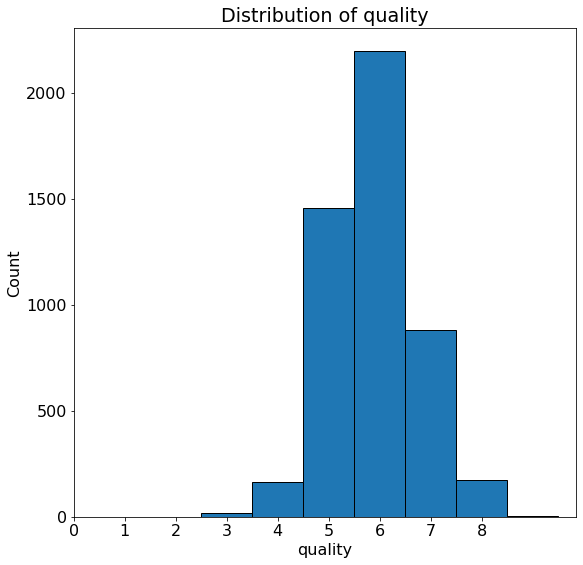

In [37]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (9, 9)

# Bar plot of grades
plt.bar(df['quality'].value_counts().index, 
        df['quality'].value_counts().values,
         fill = 'navy', edgecolor = 'k', width = 1)
plt.xlabel('quality'); 
plt.ylabel('Count'); 
plt.title('Distribution of quality');
plt.xticks(list(range(0, 9)));

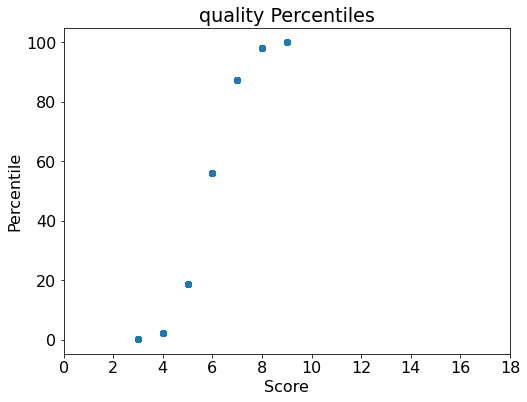

In [38]:
# Calculate percentile for grades
data['percentile'] = data['quality'].apply(lambda x: percentileofscore(data['quality'], x))

# Plot percentiles for grades
plt.figure(figsize = (8, 6))

plt.plot(data['quality'], data['percentile'], 'o')

plt.xticks(range(0, 20, 2), range(0, 20, 2))

plt.xlabel('Score'); 
plt.ylabel('Percentile'); 
plt.title('quality Percentiles');

In [39]:
# Variable Correlations with Final Grade

data.corr()['quality'].sort_values(ascending=False)

quality                 1.000000
percentile              0.978780
alcohol                 0.435575
pH                      0.099427
sulphates               0.053678
free sulfur dioxide     0.008158
citric acid            -0.009209
residual sugar         -0.097577
fixed acidity          -0.113663
total sulfur dioxide   -0.174737
volatile acidity       -0.194723
chlorides              -0.209934
density                -0.307123
Name: quality, dtype: float64

In [40]:
data = data.drop(['percentile'], axis = 1)

In [41]:
data.columns = [c.replace(' ', '_') for c in data.columns]

In [42]:
data.head(1)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
3962,7.2,0.58,0.27,5.8,0.032,40.0,118.0,0.99088,3.17,0.53,13.0,7


In [43]:
# attributes = ["quality", "fixed_acidity", "volatile_acidity", "citric_acid", "chlorides", "total_sulfur_dioxide", "density", "alcohol"]

# scatter_matrix(data[attributes], figsize=(15, 12))

<AxesSubplot:title={'center':'Scatter Plot'}, xlabel='density', ylabel='quality'>

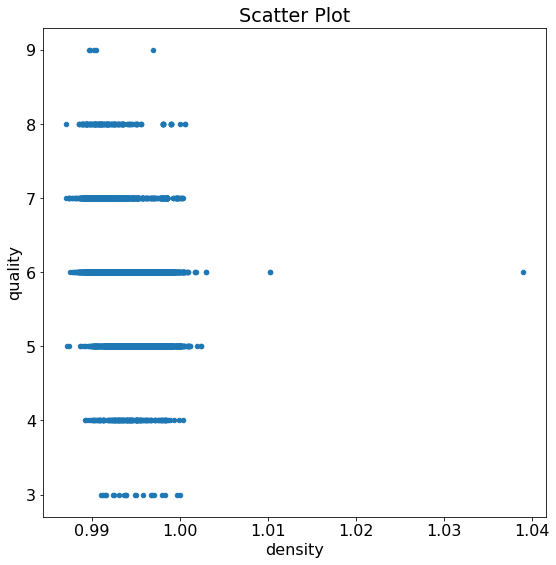

In [44]:
df.plot(title="Scatter Plot", kind="scatter", x="density", y="quality")

In [45]:
# # Calculate correlation coefficient
# def corrfunc(x, y, **kws):
#     r, _ = pearsonr(x, y)
#     ax = plt.gca()
#     ax.annotate("r = {:.2f}".format(r),
#                 xy=(.1, .6), xycoords=ax.transAxes,
#                size = 24)
    
# cmap = sns.cubehelix_palette(light=1, dark = 0.1,
#                              hue = 0.5, as_cmap=True)

# sns.set_context(font_scale=2)

# # Pair grid set up
# g = sns.PairGrid(data)

# # Scatter plot on the upper triangle
# g.map_upper(plt.scatter, s=10, color = 'red')

# # Distribution on the diagonal
# g.map_diag(sns.distplot, kde=False, color = 'red')

# # Density Plot and Correlation coefficients on the lower triangle
# g.map_lower(sns.kdeplot, cmap = cmap)
# g.map_lower(corrfunc);

In [46]:
data = data.drop_duplicates()

In [47]:
data.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000
mean,6.839346,0.280538,0.334332,5.914819,0.045905,34.889169,137.193512,0.993790,3.195458,0.490351,10.589358,5.854835
std,0.866860,0.103437,0.122446,4.861646,0.023103,17.210021,43.129065,0.002905,0.151546,0.113523,1.217076,0.890683
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.600000,0.035000,23.000000,106.000000,0.991620,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,4.700000,0.042000,33.000000,133.000000,0.993500,3.180000,0.480000,10.400000,6.000000
75%,7.300000,0.330000,0.390000,8.900000,0.050000,45.000000,166.000000,0.995710,3.290000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [48]:
data.head(1)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
3962,7.2,0.58,0.27,5.8,0.032,40.0,118.0,0.99088,3.17,0.53,13.0,7


In [49]:
data = data.drop(['residual_sugar'],axis=1)
data = data.drop(['alcohol'],axis=1)
data = data.drop(['free_sulfur_dioxide'],axis=1)

In [50]:
data.head(1)

,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,density,pH,sulphates,quality
3962,7.2,0.58,0.27,0.032,118.0,0.99088,3.17,0.53,7


scatter data

In [51]:
labels = np.array(data['quality'])
samples = data.drop(['quality'],axis=1)
print(len(labels))
print(len(samples))

3961
3961


In [52]:
def partition(input_fea, label, ratio):
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    
    test_size = int(len(input_fea)*ratio)
    train_size = len(input_fea) - test_size

    fea = input_fea.values.tolist()
    for index in range(len(fea)):
        if(index<train_size):
            train_x.append(fea[index]) 
            train_y.append(label[index])
        else:
            test_x.append(fea[index]) 
            test_y.append(label[index])
    return np.array(train_x), np.array(train_y), np.array(test_x), np.array(test_y)

In [82]:
train_x, train_y, test_x, test_y = partition(samples, labels, 0.2)

In [83]:
train_x.shape

(3169, 8)

In [55]:
from sklearn.preprocessing import StandardScaler

In [56]:
scaler = StandardScaler()
scaler.fit(train_x)
train_standard = scaler.transform(train_x)
test_standard = scaler.transform(test_x)

In [57]:
train_standard[:2]

array([[ 0.40466327,  2.92625931, -0.52918309, -0.60485195, -0.45035623,
        -1.0015163 , -0.15275914,  0.35863537],
       [ 2.24989429,  0.49166639,  0.8368294 , -0.95127027, -1.17657248,
        -0.72274046, -1.5584516 , -0.78385623]])

In [58]:
train_mean = np.mean(train_x, axis=0)
test_mean = np.mean(test_x, axis=0)

In [59]:
train_mean

array([6.84911644e+00, 2.79512464e-01, 3.35856737e-01, 4.59681287e-02,
       1.37224361e+02, 9.93825891e-01, 3.19282108e+00, 4.89192174e-01])

In [84]:
def standard_fea(arr, mean_arr):
    train_standard = []
    for col in range(arr.shape[1]):
        temp_col = []
        std_v = 0
        for ele in arr[:, col]:
            std_v = std_v+(ele - mean_arr[col])**2
            
        math.sqrt(std_v/np.array(arr).shape[1])
        for ele in arr[:, col]:
            new_value = (ele-mean_arr[col])/std_v
            temp_col.append(new_value)
        train_standard.append(temp_col)
    train_standard = np.array(train_standard)
    train_standard = np.transpose(train_standard)

    return train_standard

In [85]:
train_standard = standard_fea(train_x, train_mean)

In [86]:
train_standard[0]

array([ 1.47265938e-04,  8.99242689e-03, -1.34180520e-03, -8.26490192e-03,
       -3.32918712e-06, -1.07442737e-01, -3.22668061e-04,  9.94581881e-04])

In [87]:
train_x[0]

array([7.2000e+00, 5.8000e-01, 2.7000e-01, 3.2000e-02, 1.1800e+02,
       9.9088e-01, 3.1700e+00, 5.3000e-01])

In [88]:
test_standard = standard_fea(test_x, test_mean)

# Part C (Model Evaluation): 30 points

### 10. Model selection via Hyperparameter tuning: Use the kFold function (known as sFold function from previous assignment) to evaluate the performance of your model over each combination of lambda, learning_rate and regularizer from the following sets: [15 pts]

In [65]:
model = Linear_Regression()
lamda = [1.0, 0, 0.1, 0.01, 0.001, 0.0001]
learning_rate = [0.1, 0.01, 0.001, 0.001]
regularizer = ['l1', 'l2']

ret_list = []

for l in lamda:
    for lr in learning_rate:
        for reg in regularizer:
            ret = sFold(5, train_standard, train_y, model, None, mse, lr, 50, None, reg, l, None)
            ret_list.append(ret)

(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)
(2532, 8)


In [66]:
l = []
for ele in ret_list:
    l.append(ele["Average_test_error"])
    print(ele["Average_test_error"])
print(min(np.array(l)))

1.9899243757212046e+203
2.282543230607933e+203
3.463821913475715e+99
7.053015123875679e+99
0.6470570604322775
0.6470779494419205
0.6470570744660668
0.6470780084569105
2.4158222453689554e+203
2.7334349392882767e+203
8.575351053721727e+99
8.5956203155889e+99
0.6470818524182305
0.6470818238268656
0.647081829659965
0.647081763383073
2.684978701497705e+203
1.6158127776868912e+203
5.814958965848892e+99
1.1793949508165553e+100
0.6470793180605657
0.6470814507201613
0.6470792877072269
0.6470813907594698
1.9965994639933764e+203
3.047946401793892e+203
7.239250177351015e+99
7.516888867817593e+99
0.6470816067225179
0.6470817217225813
0.6470814969583474
0.6470817743507038
2.9076391404236505e+203
1.575570263575414e+203
2.0448050804898233e+99
6.933167443846495e+99
0.647081738120996
0.6470817461613146
0.6470818145687158
0.6470818455022511
3.604410217618664e+203
5.1612781303327136e+203
7.90557135401031e+99
1.1001290854929028e+100
0.6470818041860775
0.6470817990490951
0.6470817914338539
0.647081781198964

### 11. Evaluate your model on the test data and report the mean squared error. [5 pts]

In [67]:
model = Linear_Regression()
model.fit(train_standard, train_y, 0.001, 50, None, 'l1', 0, None)

In [68]:
pred_Y = model.predict(test_standard)

In [69]:
err = mse(test_y, pred_Y)
err

0.7147517798609263

### 12. Using the best model plot the learning curve. Use the rmse values obtained from the “learning_curve” function to plot this curve. [5 pts]

In [70]:
train_err, val_err = train_val_mse(model, train_standard, train_y, 5, 100, 0.001, 50, None, 'l1', 0, None)

(76, 8)
(76, 8)
(76, 8)
(76, 8)
(76, 8)
(156, 8)
(156, 8)
(156, 8)
(156, 8)
(156, 8)
(236, 8)
(236, 8)
(236, 8)
(236, 8)
(236, 8)
(316, 8)
(316, 8)
(316, 8)
(316, 8)
(316, 8)
(396, 8)
(396, 8)
(396, 8)
(396, 8)
(396, 8)
(472, 8)
(472, 8)
(472, 8)
(472, 8)
(472, 8)
(552, 8)
(552, 8)
(552, 8)
(552, 8)
(552, 8)
(632, 8)
(632, 8)
(632, 8)
(632, 8)
(632, 8)
(712, 8)
(712, 8)
(712, 8)
(712, 8)
(712, 8)
(792, 8)
(792, 8)
(792, 8)
(792, 8)
(792, 8)
(868, 8)
(868, 8)
(868, 8)
(868, 8)
(868, 8)
(948, 8)
(948, 8)
(948, 8)
(948, 8)
(948, 8)
(1028, 8)
(1028, 8)
(1028, 8)
(1028, 8)
(1028, 8)
(1108, 8)
(1108, 8)
(1108, 8)
(1108, 8)
(1108, 8)
(1188, 8)
(1188, 8)
(1188, 8)
(1188, 8)
(1188, 8)
(1264, 8)
(1264, 8)
(1264, 8)
(1264, 8)
(1264, 8)
(1344, 8)
(1344, 8)
(1344, 8)
(1344, 8)
(1344, 8)
(1424, 8)
(1424, 8)
(1424, 8)
(1424, 8)
(1424, 8)
(1504, 8)
(1504, 8)
(1504, 8)
(1504, 8)
(1504, 8)
(1584, 8)
(1584, 8)
(1584, 8)
(1584, 8)
(1584, 8)
(1660, 8)
(1660, 8)
(1660, 8)
(1660, 8)
(1660, 8)
(1740, 8)
(1740

In [71]:
val_err

[7.765472002274525,
 1.873251150350724,
 0.8718338825376692,
 0.724652622999001,
 0.6789706985528653,
 0.6578795997711823,
 0.6749858660757784,
 0.6704936085766057,
 0.6670516508834959,
 0.644100362311627,
 0.644076632823819,
 0.6393608414542086,
 0.6506136975560917,
 0.6538281711801293,
 0.6499164706027265,
 0.6578830626285038,
 0.6538872086774592,
 0.6599329718115076,
 0.6614539138064393,
 0.6673427364743618,
 0.662280844212546,
 0.6582270198681076,
 0.653019841131463,
 0.6525995906007175,
 0.6533378457765868,
 0.6510289830714963,
 0.6524564427357205,
 0.6507869148937654,
 0.6467765143744708,
 0.6424151922324061,
 0.6501185571207003,
 0.6470818349701566]

In [72]:
train_err

[7.0387632122386234,
 1.71944763910868,
 0.8174999559558307,
 0.6780020760319367,
 0.6430814600245228,
 0.6252974999872817,
 0.6449188408885492,
 0.6527543141445848,
 0.6498239835987285,
 0.6290538141358277,
 0.633455987709912,
 0.6278239147410394,
 0.6421043673518632,
 0.6458810227066214,
 0.6409885970736692,
 0.6477094766176239,
 0.6485661107824713,
 0.6514280362977327,
 0.6520295384518282,
 0.6582220033381599,
 0.6549099807822049,
 0.6521338837338894,
 0.6474961541126247,
 0.6470637961745231,
 0.6475182955299725,
 0.6452427145047708,
 0.6461064493638741,
 0.6454148057483876,
 0.6410608679892246,
 0.6376943934696195,
 0.6425884507161659,
 0.6394480655488126]

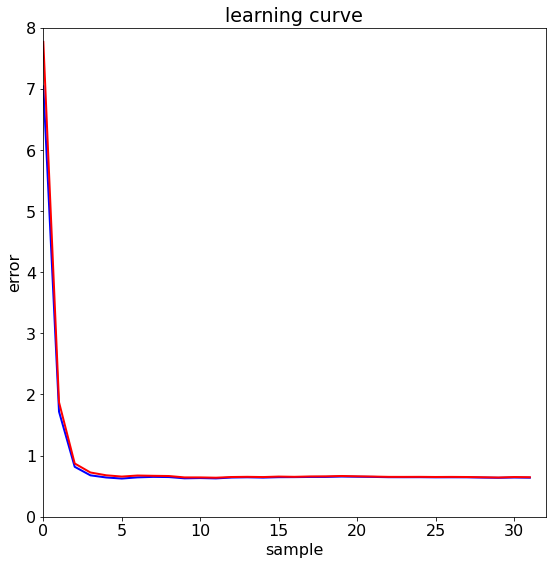

<Figure size 648x648 with 0 Axes>

In [73]:
def plot_fun(train_err, val_err):
    plt.figure()

    samples = range(32)
    plt.plot(samples,train_err, color='b',
             lw=2, label='train learning curve')
    plt.plot(samples,val_err,  color='r',
             lw=2, label='validation curve')
    #plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


    plt.xlim([0, 32])
    plt.ylim([0.00, 8])
    plt.xlabel('sample') 
    plt.ylabel('error') 
    plt.title('learning curve') 
    plt.show 

    plt.figure()

plot_fun(train_err, val_err)

### 13. Determine the best model hyperparameter values for the training data matrix with polynomial degree 3 and plot the learning curve. Use the rmse values obtained from the “learning_curve” function to plot this curve. [5 pts]

In [74]:
poly = PolynomialFeatures(3)                      # [a, b]->[1, a, b, a^2, ab, b^2]
poly.fit(train_x)
new_train = poly.transform(train_x)
new_test = poly.transform(test_x)

In [75]:
scaler = StandardScaler()
scaler.fit(new_train)
train_standard = scaler.transform(new_train)
test_standard = scaler.transform(new_test)

In [76]:
model = Linear_Regression()
lamda = [1.0, 0, 0.1, 0.01, 0.001, 0.0001]
learning_rate = [0.1, 0.01, 0.001, 0.001]
regularizer = ['l1', 'l2']

ret_list = []

for l in lamda:
    for lr in learning_rate:
        for reg in regularizer:
            ret = sFold(5, train_standard, train_y, model, None, mse, lr, 50, None, reg, l, None)
            ret_list.append(ret)

(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(2532, 165)
(253

In [77]:
l = []
for ele in ret_list:
    l.append(ele["Average_test_error"])
    print(ele["Average_test_error"])
print(min(np.array(l)))

3.051939046690324e+221
1.1325610585380839e+221
1.0937237755808805e+119
1.9175579253984832e+119
2.3186771826472135
2.3052949327473
2.255596896179498
2.297233967680918
3.884055646536252e+221
1.7448496951800046e+221
1.1369361522692737e+119
4.929996783842272e+118
2.271091223262813
2.2859310260731096
2.2806010502654637
2.2603147366910883
2.285939194446338e+221
6.149130069128089e+221
9.656229496651849e+117
1.4961823581836012e+119
2.2644285508780495
2.2627162903330658
2.239021057495176
2.2827024987210978
6.996689743392749e+220
7.274132513521804e+220
4.3329133581363276e+119
4.376830464718065e+119
2.3243653272736107
2.272498660995973
2.295042839835691
2.2905671500219937
1.493466411515705e+221
2.9849916986032735e+221
3.564842384238125e+119
1.9207176498211597e+118
2.280825769645085
2.241725321581844
2.2711320412935256
2.236442124426979
6.511177617227374e+221
3.6386618922778793e+220
4.2370136535369375e+118
6.643974360129806e+119
2.250310948350914
2.2808172476907806
2.289062261011325
2.275437281204

In [78]:
model = Linear_Regression()
model.fit(train_standard, train_y, 0.001, 50, None, 'l1', 0.0001, None)

In [79]:
pred_Y = model.predict(test_standard)
err = mse(test_y, pred_Y)
err

5.363014080274614

In [80]:
train_err, val_err = train_val_mse(model, train_standard, train_y, 5, 100, 0.001, 50, None, 'l1', 0.0001, None)

(76, 165)
(76, 165)
(76, 165)
(76, 165)
(76, 165)
(156, 165)
(156, 165)
(156, 165)
(156, 165)
(156, 165)
(236, 165)
(236, 165)
(236, 165)
(236, 165)
(236, 165)
(316, 165)
(316, 165)
(316, 165)
(316, 165)
(316, 165)
(396, 165)
(396, 165)
(396, 165)
(396, 165)
(396, 165)
(472, 165)
(472, 165)
(472, 165)
(472, 165)
(472, 165)
(552, 165)
(552, 165)
(552, 165)
(552, 165)
(552, 165)
(632, 165)
(632, 165)
(632, 165)
(632, 165)
(632, 165)
(712, 165)
(712, 165)
(712, 165)
(712, 165)
(712, 165)
(792, 165)
(792, 165)
(792, 165)
(792, 165)
(792, 165)
(868, 165)
(868, 165)
(868, 165)
(868, 165)
(868, 165)
(948, 165)
(948, 165)
(948, 165)
(948, 165)
(948, 165)
(1028, 165)
(1028, 165)
(1028, 165)
(1028, 165)
(1028, 165)
(1108, 165)
(1108, 165)
(1108, 165)
(1108, 165)
(1108, 165)
(1188, 165)
(1188, 165)
(1188, 165)
(1188, 165)
(1188, 165)
(1264, 165)
(1264, 165)
(1264, 165)
(1264, 165)
(1264, 165)
(1344, 165)
(1344, 165)
(1344, 165)
(1344, 165)
(1344, 165)
(1424, 165)
(1424, 165)
(1424, 165)
(1424, 16

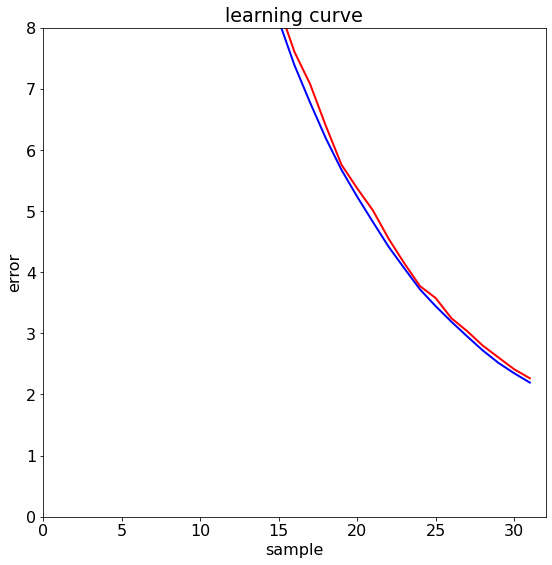

<Figure size 648x648 with 0 Axes>

In [81]:
plot_fun(train_err, val_err)